In [ ]:
!pip install datasets[audio] transformers

In [2]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /root/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696. Subsequent calls will reuse this data.


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [3]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

## Resampling

In [4]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [5]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

As we made sampling rate 2X, the number of elements would also double

Some background on resampling: If an audio signal has been sampled at 8 kHz, so that it has 8000 sample readings per second, we know that the audio does not contain any frequencies over 4 kHz. This is guaranteed by the Nyquist sampling theorem. Because of this, we can be certain that in between the sampling points the original continuous signal always makes a smooth curve. Upsampling to a higher sampling rate is then a matter of calculating additional sample values that go in between the existing ones, by approximating this curve. Downsampling, however, requires that we first filter out any frequencies that would be higher than the new Nyquist limit, before estimating the new sample points. In other words, you can't downsample by a factor 2x by simply throwing away every other sample — this will create distortions in the signal called aliases.

## Filtering Dataset

In [6]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [7]:
# use librosa to get example's duration from the audio file
import librosa
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

## Preprocessing Audio

### Whisper Feature Extractor

 Whisper feature extractor pads/truncates a batch of audio examples such that all examples have an input length of 30s. Examples shorter than this are padded to **30s** by **appending zeros** to the end of the sequence (zeros in an audio signal correspond to no signal or silence). Examples longer than 30s are **truncated to 30s**. Since all elements in the batch are padded/truncated to a maximum length in the input space, there is **no need for an attention mask**. Whisper is unique in this regard, most other audio models require an attention mask that details where sequences have been padded, and thus where they should be ignored in the self-attention mechanism. Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs.

The second operation that the Whisper feature extractor performs is converting the padded audio arrays to log-mel spectrograms. As you recall, these spectrograms describe how the frequencies of a signal change over time, expressed on the mel scale and measured in decibels (the log part) to make the frequencies and amplitudes more representative of human hearing.

So to summarize


1.   Whisper first Pad/Truncate upto 30 seconds
2.   COnverts array to Log Mel Spectogram



In [9]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [10]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [11]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

we now have log-mel spectrograms as input_features in the dataset.

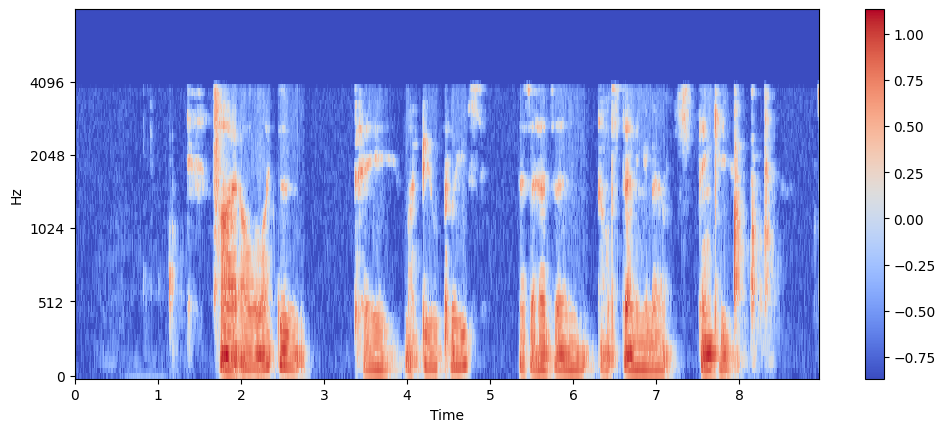

In [12]:
import numpy as np
import matplotlib.pyplot as plt


example = minds[10]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [14]:
type(input_features)

list

The model’s feature extractor class takes care of transforming raw audio data to the format that the model expects. However, many tasks involving audio are multimodal, e.g. speech recognition. In such cases 🤗 Transformers also offer model-specific tokenizers to process the text inputs.

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")